# Прогнозирование оттока клиентов банка.

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно было спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 


Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Загрузили датасет и ознакомились. Для прогнозирования оттока клиентов нам не нужны первые 3 столбца. Удалим их.

In [2]:
target = data['Exited']
features = data.iloc[:,3:13]
features.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


In [3]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


2 столбца (Geography и Gender) имеют тип данных object. А также есть пропуски в столбце Tenure (количество недвижимости). Пропуски заменим на нули, Geography и Gender преобразуем с помощью ohe.

In [4]:
features['Tenure'] = features['Tenure'].fillna(0)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


In [5]:
features = pd.get_dummies(features, drop_first = True)
features.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,1


Данные подготовлены, приступим к исследованию.

# 2. Исследование задачи

Вначале необходимо исследовать баланс классов.

In [6]:
target_0 = data[data['Exited'] == 0]['Exited'].count()
target_1 = data[data['Exited'] == 1]['Exited'].count()
print('Количество целевых признаков 1:', target_1)
print('Количество целевых признаков 0:', target_0)

Количество целевых признаков 1: 2037
Количество целевых признаков 0: 7963


Данные сильно не сбалансированы. Количество "1" всего 20% от общего количества целевых признаков. Попробуем решить задачу как есть и посмотрим, что получится. Но перед этим необходимо разбить выборку на тренировочную, валидационную и тестовую в соотношении 60% : 20% : 20%

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, 
                                                                              test_size=0.5, random_state=12345)
model = LogisticRegression(solver='liblinear', random_state=12345) 
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

0.13441955193482688


Пока у нас F1 оценка получилась 0,13 при целевом значении не ниже 0,59. Попробуем другие алгоритмы обучения.

In [8]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

0.47515151515151516


Дерево решений получше. Попробуем еще случайный лес:

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

0.5070422535211269


Лучше, но не достаточно. Попробуем в следующих разделах исключить дисбаланс и покрутить параметры случайного леса для выхода на нужный уровень f1 score.

# 3. Борьба с дисбалансом

In [10]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]
repeat = 4
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 11)
(9588,)


Увеличили количество "1" в 4 раза, так как их было примерно в 4 раза меньше. Теперь необходимо перемешать.

In [11]:
from sklearn.utils import shuffle
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

Проверим, что получилось

In [12]:
model = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

0.592274678111588


Также есть другой способ больбы с дисбалансом - downsample

In [13]:
features_downsampled = pd.concat([features_zeros.sample(frac=0.25, random_state=12345)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac=0.25, random_state=12345)] + [target_ones])
model = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

0.5708920187793428


Метод upsample дает лучший результат. Мы уже выходим на целевой уровень f1. Попробуем подобрать наилучшее значение depth и n_estimators для случайного леса.

In [14]:
best_f1 = 0.59
best_depth = 0
best_estimators = 0
for depth in range(2, 15, 1):
    for estimators in range (10, 100, 10):
        model = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_estimators = estimators
print('Лучшая f1 оценка =', best_f1, 'при depth = ', best_depth, 'при n_estimators = ', best_estimators)

Лучшая f1 оценка = 0.6197502837684449 при depth =  11 при n_estimators =  30


После устранение дисбаланса мы смогли выйти на нужный уровень f1 оценки. Также подобрали наилучшие параметры для случайного леса чтобы максимизировать ее.

# 4. Тестирование модели

Проверим работу нашей модели на тестовой части выборки.

In [15]:
model = RandomForestClassifier(n_estimators = 30, max_depth = 11, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
f1 = f1_score(target_test, predicted_test)
print('Оценка f1 на тестовой выборке:', f1)

Оценка f1 на тестовой выборке: 0.612756264236902


In [17]:
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('auc_roc =', auc_roc)

auc_roc = 0.8432613613680218


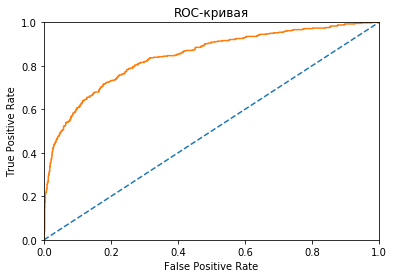

In [18]:
from sklearn.metrics import roc_curve 
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Из графика видно, что Roc кривая выше случайной модели, auc_roc мы рассчитали равной 0.84, что является достаточным уровнем.